In [1]:
import time
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pybullet as p
import pybullet_data

import torch
from torch_cluster import radius_graph, radius
from torch_scatter import scatter

import edf
from edf.pybullet_env.utils import get_image, axiscreator, img_data_to_pointcloud
from edf.visual_utils import plot_color_and_depth, scatter_plot, scatter_plot_ax, visualize_samples, visualize_sample_cluster
from edf.pybullet_env.env import MugTask

device = 'cpu'
#gpu_idx = 0
#torch.cuda.set_device(gpu_idx)

pybullet build time: Dec  1 2021 18:34:28
/home/hw/anaconda3/envs/SE3_Transporter/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gzip
import pickle

folder_name = 'demo'
task_name = 'mug_task'
path = f'{folder_name}/{task_name}'

with gzip.open(path + f'/upright.gzip','rb') as f:
    upright_samples = pickle.load(f)

with gzip.open(path + f'/lying.gzip','rb') as f:
    lying_samples = pickle.load(f)

# Learning Pick

In [3]:
from pytorch3d import transforms

import e3nn.nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace, soft_unit_step

from edf.utils import preprocess
from edf.models import SE3Transformer, SE3TransformerLight, EnergyModel
from edf.mcmc import MH, LangevinMH
from edf.dist import GaussianDistSE3

characteristic_length = 0.01

In [4]:
N_query = 1
max_radius = 3.
query_radius = 0.
field_cutoff = 5.
std_theta = 45 / 180 * np.pi
std_X = 5.                      
ranges_cropped = torch.tensor([[-21., 21.],
                               [-21., 21.],
                               [-30., -5.]])
irreps_out = "10x0e + 10x1e + 4x2e + 2x3e"
irreps_descriptor = o3.Irreps(irreps_out)
sh_lmax_descriptor = 3
number_of_basis_descriptor = 10
irrep_normalization = 'norm'

In [5]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
torch.set_printoptions(precision=4, sci_mode=False)

In [6]:
se3T = SE3TransformerLight(max_neighbor_radius = max_radius, irreps_out=irreps_out)
irreps_out = o3.Irreps(se3T.irreps_out)
energy_model = EnergyModel(N_query = N_query, query_radius = query_radius, field_cutoff = field_cutoff,
                           irreps_input = irreps_out, irreps_descriptor = irreps_descriptor, sh_lmax = sh_lmax_descriptor, number_of_basis = number_of_basis_descriptor, ranges = ranges_cropped)
metropolis = MH(ranges_X = ranges_cropped, std_theta = std_theta, std_X = std_X)
langevin = LangevinMH(ranges_X = ranges_cropped, dt = 0.1, std_theta = 1., std_X = 1.)

In [7]:
tp_pickle_path = "reproducible_pickles/"

#se3T.save_tp(tp_pickle_path + "se3T/")
#energy_model.save_tp(tp_pickle_path + "energy_model/")
se3T.load_tp(tp_pickle_path + "se3T/")
energy_model.load_tp(tp_pickle_path + "energy_model/")

In [8]:
if device == 'cuda':
    se3T = se3T.to(device)
    energy_model = energy_model.to(device)
    metropolis = metropolis.to(device)
    langevin = langevin.to(device)

metropolis.get_inv_cdf()
langevin.get_inv_cdf()

In [9]:
lr_se3T = 5e-3
lr_energy = 20e-3

optimizer_se3T = torch.optim.Adam(list(se3T.parameters()), lr=lr_se3T, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
optimizer_energy = torch.optim.Adam(list(energy_model.parameters()), lr=lr_energy, betas=(0.9, 0.98), eps=1e-09, weight_decay=0, amsgrad=True)

#perturb_dist = GaussianDistSE3(std_theta = 5 / 180 * np.pi, std_X = 2.5 * 0.2).to(device)
perturb_dist = GaussianDistSE3(std_theta = 10 / 180 * np.pi, std_X = 2.5 * 0.2).to(device)

train_samples = upright_samples[:10]
test_samples = upright_samples[10:12] + lying_samples[10:12]

100%|██████████| 299/299 [00:18<00:00, 15.86it/s]


=========Iter 1=========


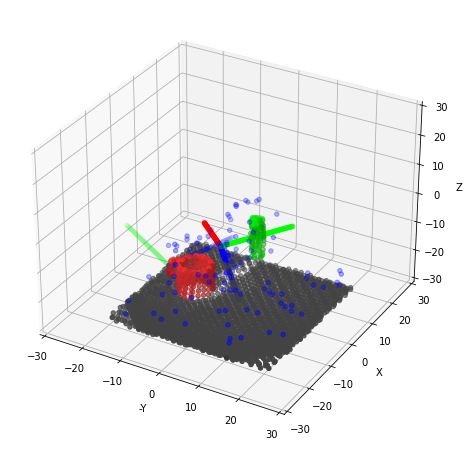

tensor([7.2759, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 6.1340, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 4.9817, 3.0000, 6.0381, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 5.2191, 4.3107, 4.4266, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 6.0343,
        3.0000, 3.0000, 3.0000, 3.0000, 3.7312, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 5.8995, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 5.1638, 3.0000, 3.0000,
        3.0000, 6.5533, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 5.9702, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 6.1621, 3.0000,
        3.0000, 3.0000])
Loss: 3.9596502780914307 || E_pos: 7.275896072387695 || E_neg_min: 2.999999523162842
Scalar coe

100%|██████████| 330/330 [00:19<00:00, 17.21it/s]


=========Iter 50=========


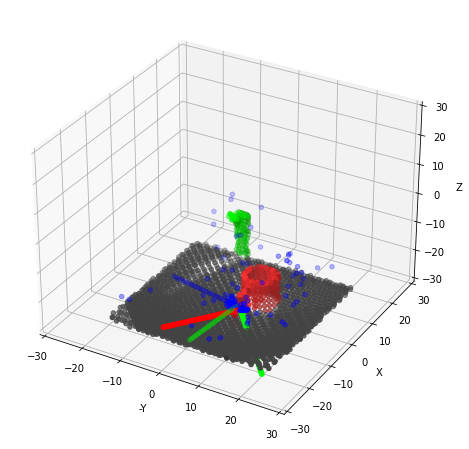

tensor([ 1.6443,  4.6223,  7.9734,  7.9734,  5.3387,  3.3141, 10.1055,  7.9734,
         5.7995,  3.5192,  2.3037,  4.2402,  2.0264,  7.9734,  2.2430,  5.4532,
         7.9734,  8.2211,  2.9862,  2.1485,  3.0543,  3.6395,  3.0915,  3.2012,
         7.9734,  3.6657,  7.9734,  7.9734,  7.9734,  3.8350,  7.9734,  6.0904,
         4.5311,  2.0079,  3.8467,  7.9734,  2.3119,  4.5899,  8.8408,  3.9465,
         5.2927,  4.4434,  7.9734,  7.9734,  6.3242,  7.1857,  7.9734,  7.9734,
         4.6907,  3.2838,  2.8225,  3.6550,  7.8765,  2.7639,  3.2896,  6.9876,
         2.9978,  7.0971,  5.3064,  7.9734,  3.5922,  5.2606,  7.9734,  7.9734,
         4.4839,  2.7146,  7.4286,  7.9734,  3.8291,  7.9734,  2.5917,  7.9734,
         4.2349,  2.2210,  1.9746,  7.9734,  9.9495,  7.9734, 16.6532,  3.5336,
         7.9734,  4.1369,  3.0198,  3.7834,  4.0767,  6.2349,  3.4367,  3.1555,
         7.9734,  3.7269,  3.7793,  3.0506,  3.6989,  7.9734,  7.9734,  2.4947,
         5.2103,  6.5786,  8.4022,  2.12

100%|██████████| 365/365 [00:26<00:00, 13.70it/s]


=========Iter 100=========


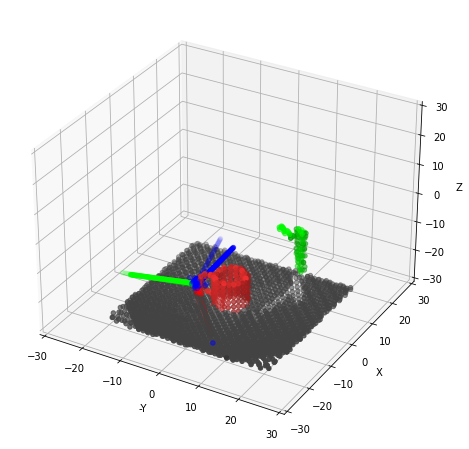

tensor([ 9.1825,  8.4215,  9.8966, 11.0953, 12.5140, 10.9614,  9.5172,  9.8786,
         8.6959,  9.5692,  9.1016, 13.0068, 11.9381,  9.8941, 10.0911, 12.5949,
        11.6202, 10.0067, 10.6127,  8.9869,  9.6980,  9.5804,  9.6545, 14.2209,
        12.1175, 15.0334,  8.2421, 11.7851, 10.3455, 10.9920, 13.1422, 12.3633,
        11.9626, 11.0930, 11.6545, 12.7289, 10.5950,  9.4915, 13.3883,  9.5528,
        10.0140, 10.2290, 18.1545,  9.0172,  8.4477,  9.0338, 10.8458,  9.3694,
         7.7501,  9.8077,  9.1210, 12.5576,  9.0134,  9.5744, 11.7846, 11.4362,
        11.0756, 14.3663,  9.7929, 10.0323, 14.0696,  8.9031, 14.6922,  9.6530,
        10.0841, 20.1489, 11.5201, 10.9737, 13.2192, 11.0038,  7.6734, 11.6985,
         9.5598, 22.0962, 10.3056, 10.6333, 13.8742,  8.6889, 13.1903, 10.4695,
         8.4426,  9.7139, 10.9781,  8.8556,  8.4322, 10.2176, 10.8943,  8.1836,
        11.1331, 15.0127,  9.8087,  8.9894, 12.3616,  8.9101, 10.1015,  8.7166,
        14.9801,  8.5481, 12.4582,  9.13

100%|██████████| 403/403 [00:27<00:00, 14.87it/s]


=========Iter 150=========


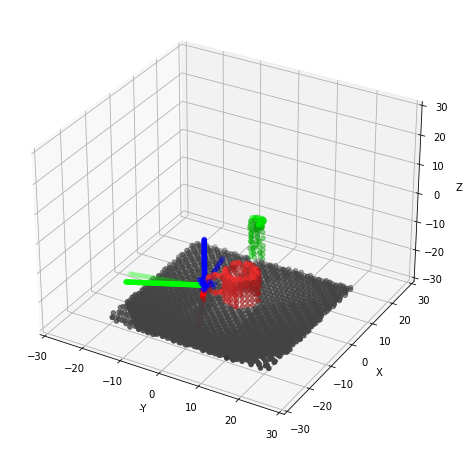

tensor([ 9.3167, 10.2715,  8.3341,  6.9228, 10.5524, 11.2744,  7.7630,  6.5785,
        13.4708,  9.4189, 10.3793,  9.5823, 11.2676,  6.5062,  6.8445,  7.3539,
         8.8940,  8.3400, 17.0425,  8.9184,  7.1600,  8.0092,  7.2726,  8.4298,
         7.6160, 11.0218, 10.3675,  7.9995,  7.1369,  9.7049, 10.1552,  8.9934,
         7.0494, 11.1639, 10.1061,  6.5974, 12.5570,  9.4241,  6.2057,  6.8444,
         7.8523,  6.5598, 19.3371,  9.0911,  9.8604,  7.2791, 14.2241, 10.0808,
         9.8662,  8.4831,  7.6123,  8.7120,  7.3218,  8.5087,  6.8468,  6.2434,
         7.6509,  5.8010,  7.4936,  8.8762,  6.1638,  8.5894,  7.7615,  8.8035,
         7.2986,  8.9281,  9.2162,  6.9412, 10.0424,  7.3929,  7.0444,  8.6962,
         9.9255,  7.3446, 10.3667,  9.3653, 10.7645,  8.5560, 12.8478, 10.4736,
        11.8564,  7.6983,  9.2516,  7.9264,  7.5334,  9.9002, 13.9713,  7.6970,
        12.5684,  9.5724,  8.6566,  7.3575, 12.5426,  9.8290,  9.3659,  6.9436,
         7.2001,  8.2095,  9.5500,  8.76

100%|██████████| 446/446 [00:29<00:00, 15.01it/s]


=========Iter 200=========


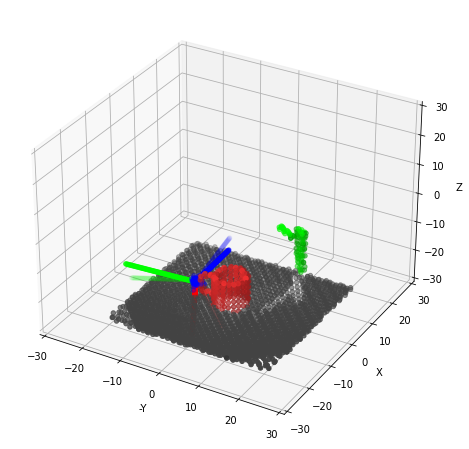

tensor([ 8.7293,  8.1149, 12.2019,  9.6232, 10.4906,  6.9051,  9.2436, 11.6860,
         7.3693,  6.9570,  9.5758, 11.5306,  7.5994,  9.7090,  8.7433,  9.5656,
         9.8751,  9.7717,  9.7616,  8.8188,  8.6283,  6.7122,  8.5368,  7.6668,
         9.0751,  7.8725,  8.9447,  9.0061,  8.4710,  8.1921,  7.9971,  9.4176,
         8.1873,  7.4331,  8.7579, 13.1928,  9.0082,  7.7269,  8.1766,  6.8898,
         8.4796,  7.3484,  8.0438,  9.6871,  7.3023,  7.0918, 10.5188, 10.8878,
        10.7931,  8.4195,  7.8545, 11.8509, 12.0961,  9.3123, 10.0073, 10.2360,
        10.5921, 16.4110, 11.2425,  8.1991,  8.5798,  8.5404,  9.0582, 10.4868,
         9.7521, 12.6789,  8.5054, 11.0503, 10.9374,  9.9334, 10.3023,  9.6332,
        12.5728,  8.1785,  8.4885,  7.8042,  8.0803, 12.6382,  8.3364,  8.5703,
        10.1862, 11.5317,  9.4209, 10.4093,  7.0142,  8.3760, 11.9512,  8.6962,
         8.0731,  9.3490,  9.7986,  8.1096, 13.0261,  7.5259,  8.0005,  7.2027,
        12.9597,  7.9407,  8.6930,  9.31

100%|██████████| 493/493 [00:36<00:00, 13.65it/s]


=========Iter 250=========


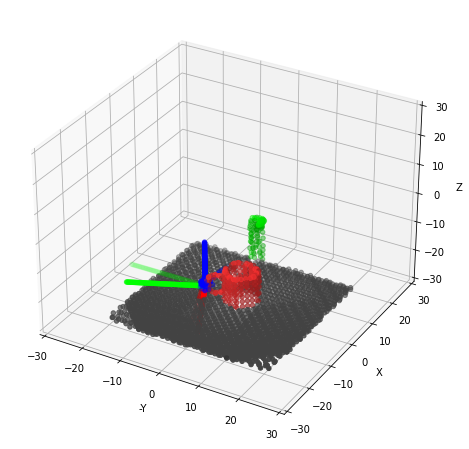

tensor([10.4557,  7.8829,  9.5449,  7.9234, 11.9826, 10.6822,  7.6429,  9.4644,
         9.9155,  6.6059,  8.1935,  8.4222, 11.4182,  7.5966,  6.4829, 10.5296,
         7.4540,  8.7856, 11.7095,  9.4772, 11.4167,  9.6816,  8.6722, 12.0187,
         8.1708,  7.4272,  7.6193,  7.5549,  9.4698,  7.6035, 11.7959,  7.3699,
        10.4264,  7.8700,  9.7746, 10.7349, 10.6612,  9.2938, 10.7797,  8.8361,
         7.8497, 11.2412, 10.9820,  9.8114,  9.6331, 12.4714, 13.6403,  8.7865,
         8.6263,  8.2461, 10.1249,  8.9705,  9.0382, 11.3780,  8.8261, 12.7391,
         8.9692, 12.9399, 11.0589,  7.9821,  8.8559,  8.2412,  8.2951,  7.5116,
        11.1029,  8.5157,  8.0897,  9.0200, 10.0563, 13.7345,  8.0067,  9.2277,
        10.1248, 13.2077,  7.5800,  9.3202,  7.4970, 11.9165,  9.8607,  6.6218,
        10.0194,  7.2210, 10.5423,  7.3272,  8.9602,  9.5005, 10.2995, 14.3672,
        11.3878,  7.5862,  8.4611,  9.9496, 10.5551,  8.7663,  7.8272,  8.4333,
         8.0866,  9.9235,  8.9106,  8.07

100%|██████████| 545/545 [00:35<00:00, 15.16it/s]


=========Iter 300=========


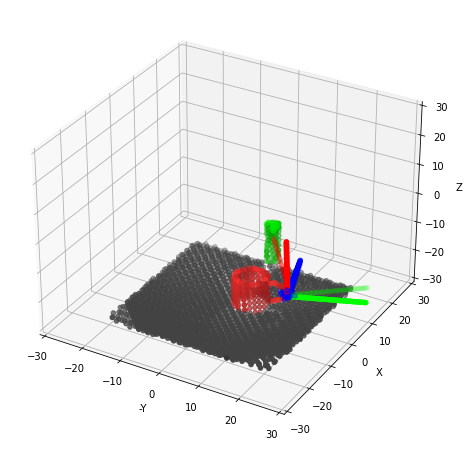

tensor([ 8.1074,  9.4187,  8.4914,  7.7557,  7.2526,  7.1804,  9.1354, 11.9103,
         7.3485,  9.0990,  8.1006,  7.3438,  9.9371,  8.7572,  9.3631,  9.0152,
        10.3056,  8.8847,  7.4559,  6.1626, 10.4637,  7.7447, 10.2425,  9.7395,
         8.0683, 10.4859, 10.5222,  8.2150,  8.5326,  7.3533,  8.6414,  7.9780,
         9.6546,  6.3206,  8.8214,  8.7237,  9.7435,  9.1193, 11.9769, 12.7792,
         8.0434, 10.0113, 10.1192, 10.3596,  7.8335, 12.6102,  8.1032, 10.2397,
         7.2537, 13.7413, 11.7664,  7.8395, 10.2289, 11.3933,  8.4128,  9.8366,
         9.6218,  7.5991,  7.0253,  8.1411,  7.9371,  8.2414,  8.6526,  6.6398,
         8.4938, 10.4964,  8.1528, 11.0060, 17.4056,  7.6109,  7.0806, 10.3940,
         7.0374, 10.2144,  6.9885,  6.8418,  8.1028,  6.8520,  9.5724,  8.1452,
        10.9641,  6.8539,  9.2414,  9.5712,  8.1908,  7.7773,  7.1324, 13.9335,
        10.9086,  9.3375, 10.3287,  7.2676, 10.2288,  8.0712,  7.3496,  8.0976,
        13.6397, 10.9329, 11.0910,  7.56

100%|██████████| 603/603 [00:40<00:00, 14.75it/s]


=========Iter 350=========


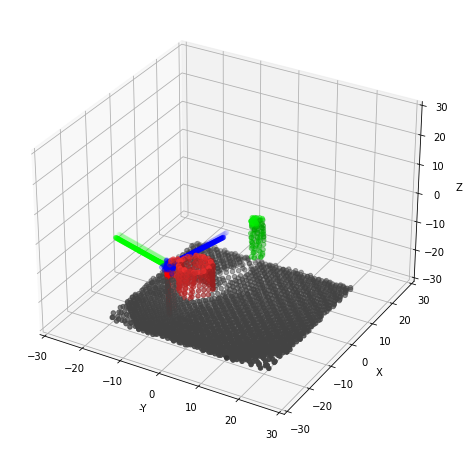

tensor([ 9.2504,  9.4421,  7.7692, 13.1100,  9.0999,  8.2307, 13.2653,  8.4342,
        12.6996,  7.5770,  8.2568, 10.1315, 13.8546,  9.7246, 11.8835,  9.5335,
         7.9386, 10.6366,  7.7558,  9.2395, 11.9747,  8.2153,  9.4636, 12.2488,
         9.3820, 10.2717, 12.6321, 11.9856,  8.3038,  8.8716, 10.6134,  8.9204,
        10.5867, 12.0798, 10.2600,  8.9191, 10.3734,  9.7096, 10.2014,  8.8364,
        11.3765, 10.2490,  8.9137, 11.0329,  9.9731,  8.6586, 12.6173,  8.7245,
        10.8321, 18.3764,  9.0719, 10.2898,  9.9855, 10.7778,  9.9320, 10.2003,
        10.9142, 10.2045,  7.6405, 10.4363,  8.5691, 10.2395, 10.0135, 11.9760,
        10.4580, 16.2378, 11.3832, 12.0296, 10.4657, 11.8153,  8.9503,  8.8391,
         9.9794, 10.2544, 10.5339, 16.5363, 11.5861,  9.7267, 12.3674,  9.1907,
         9.7081, 13.8170,  8.8689,  9.2078, 12.0387, 10.1836, 11.8104, 11.8182,
        11.0573,  8.1353,  8.4678,  9.4439, 11.1140,  8.5776, 10.0712, 13.6709,
         7.9677,  9.0846, 13.0132,  7.81

100%|██████████| 666/666 [00:41<00:00, 15.92it/s]


=========Iter 400=========


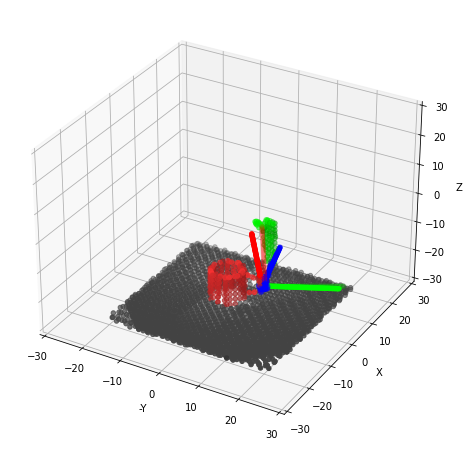

tensor([ 8.7132, 11.8903, 10.7978,  7.7327, 10.6564, 16.8225, 10.2211, 10.0663,
        13.9760,  9.1426, 12.9532,  9.9278, 12.1092,  7.9252,  8.1386,  9.3048,
        10.2860,  8.7836,  7.9486, 12.1059, 11.1289,  9.0570,  9.3076, 11.1942,
         8.9592,  7.8929, 12.9699,  8.4996, 10.0353,  9.9864, 11.4451, 15.5596,
        10.6301, 13.6777, 11.7204,  9.1089, 13.2425, 11.1904, 12.9289, 11.1177,
         9.6402,  9.1545, 10.6612,  9.5616,  8.4615, 11.0043, 11.2370,  9.9015,
         9.3205,  9.5063, 10.4641,  8.8665,  9.6092, 11.0789,  8.2398,  9.8980,
         9.8078,  7.7128, 12.4024,  8.8425, 10.5589,  8.0673,  8.2874, 11.4993,
        19.1543, 12.2116,  8.1093, 11.2192, 10.6575, 15.0696, 10.3688, 12.4061,
         7.7972,  8.0279,  8.3152,  7.9981,  9.8800,  9.5226, 11.3683, 10.6016,
         9.3216, 12.1638, 10.7129, 13.4071, 13.9737, 12.2304,  8.8056, 11.2209,
         8.6027,  8.0281,  9.7309, 13.0032,  8.8896, 10.3351, 13.0473, 15.2719,
         8.2802,  9.0343, 11.6599,  9.49

100%|██████████| 736/736 [00:52<00:00, 13.95it/s]


=========Iter 450=========


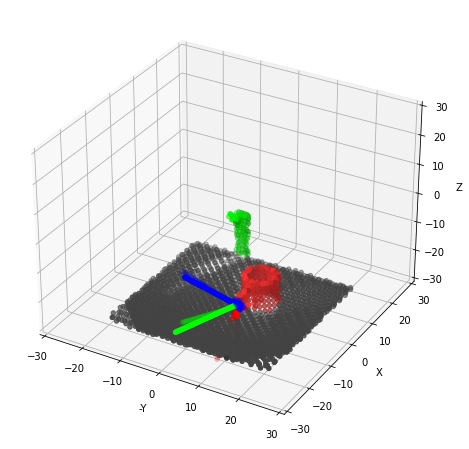

tensor([10.0396,  9.9239,  8.4104, 12.5166,  9.7150, 12.3722,  8.6546, 10.5836,
         7.6181,  7.6718, 10.2322,  7.4225, 13.4110, 11.2770, 11.5836, 13.2441,
         8.2347,  8.3715, 13.7963,  6.9701, 15.3591,  8.7535, 11.0237,  8.6335,
        11.0891,  7.8454,  8.3303,  8.7143,  9.8659,  8.5023,  7.5783, 16.2129,
         8.8035,  8.4235, 10.6997, 10.8296,  8.7891,  8.6114,  8.7690,  7.5242,
        11.9925,  9.7109,  8.7228, 10.3753,  9.2183, 10.0063,  8.8132, 12.6412,
        12.1125, 10.4050, 10.4726, 10.5357,  9.4434,  8.2424,  8.9861, 11.2781,
         7.5048, 10.0109,  9.5555,  9.6057,  9.6632, 14.0276,  8.2193, 12.2306,
         8.1939, 13.2982,  9.3768, 11.7025, 10.4394,  8.8034, 10.2902, 12.3028,
        15.7259,  8.3466, 14.2456,  9.3749,  9.9089,  8.5549, 10.6871,  8.6607,
        13.0840, 10.9169,  7.8801,  9.2663, 11.2004,  8.6736,  7.4993,  9.5211,
        10.2260,  8.2610, 12.7963,  9.8625,  9.3843, 10.6527, 11.9077,  9.0160,
         9.6576, 10.0436,  7.8338, 11.64

100%|██████████| 814/814 [00:52<00:00, 15.50it/s]


=========Iter 500=========


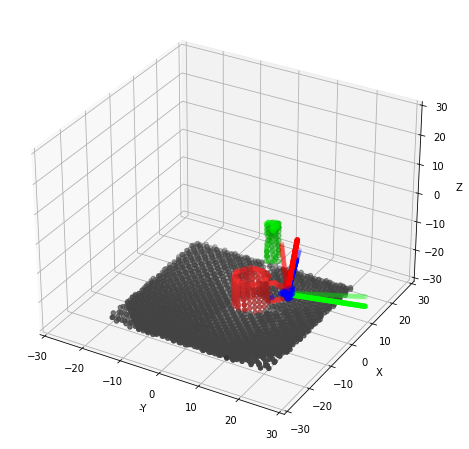

tensor([ 6.9297,  9.9177, 12.0372,  7.4572,  9.1149, 12.0504,  7.4720, 10.8424,
         8.1474, 10.6414,  8.6409, 13.7594,  8.8077,  9.4564, 14.1313,  9.5284,
         8.0521, 10.6205,  8.7390, 15.5887,  8.6041, 10.1546, 10.7185,  9.6137,
         9.2742, 12.7286, 11.6187, 12.0655,  7.4723,  8.1626, 11.5542, 14.8344,
        11.5662, 10.0347, 10.3165,  9.4962,  9.3978, 10.2693, 13.4396,  8.7725,
         7.0633,  8.8268, 11.2989,  9.6306,  8.2495, 11.4802, 14.7000, 10.6758,
        10.7261,  7.0403, 10.1065,  7.3667,  8.1249,  7.7218,  7.9314,  8.1581,
         9.2076,  7.1800, 11.0292,  8.7885, 10.7259,  8.1340,  7.5333,  7.9305,
         9.7587,  8.1871, 10.2518,  9.6713,  8.4417,  8.9736,  7.1787, 13.8431,
         7.2662, 10.2637,  8.9276, 13.5113,  7.4964,  9.9161, 10.7833,  8.3453,
        12.1898,  8.5837, 11.6984,  9.7502, 10.0634,  7.7889, 10.5462,  8.2205,
         8.4946, 11.4032,  7.5003,  9.3069, 10.8801,  8.9357,  6.9924,  8.0753,
         8.1612,  7.9441, 11.8220,  8.33

In [10]:
save_checkpoint = True
PATH = f'checkpoint/train_pick_reproducible/{datetime.datetime.now().strftime("%b_%d_%Y__%H_%M_%S")}'
if save_checkpoint:
    if os.path.exists(PATH) is False:
        os.makedirs(PATH)

    torch.save({'se3T_state_dict': se3T.state_dict(),
                'energy_model_state_dict': energy_model.state_dict(),
                }, PATH + f'/model_iter_{0}.pt')

max_epochs = 50
max_iter = len(train_samples) * max_epochs

iter = 0
for epoch in range(1, max_epochs+1):
    train_sample_indices = list(range(10))
    np.random.shuffle(train_sample_indices)
    for train_sample_idx in train_sample_indices:
        iter += 1
        sample = train_samples[train_sample_idx]

        t1 = time.time()
        temperature = 1.

        train_sample_idx = np.random.randint(len(train_samples))
        sample = train_samples[train_sample_idx]

        color_unprocessed = sample['color']
        sample = preprocess(sample, characteristic_length)

        coord, color, ranges = sample['coord'], sample['color'], sample['ranges']
        X_sdg, R_sdg = sample['grasp'][0], sample['grasp'][1]
        data_transform = sample['data_transform']

        ##### Prepare input
        target_pos = torch.tensor(X_sdg, dtype=torch.float32).unsqueeze(0).to(device) # (1, 3)
        target_orn = torch.tensor(R_sdg, dtype=torch.float32).unsqueeze(0).to(device) # (1, 3, 3)
        feature = torch.tensor(color, dtype=torch.float32)
        pos = torch.tensor(coord, dtype=torch.float32)
        in_range_cropped_idx = (((pos[:] > ranges_cropped[:,0]) * (pos[:] < ranges_cropped[:,1])).sum(dim=-1) == 3).nonzero().squeeze(-1)
        pos = pos[in_range_cropped_idx].to(device)
        feature = feature[in_range_cropped_idx].to(device)

        inputs = {'feature': feature, 'pos': pos, 'edge': None, 'max_neighbor_radius': max_radius}
        target_T = torch.cat([transforms.matrix_to_quaternion(target_orn), target_pos], dim=-1)
        target_T = perturb_dist.propose(target_T)
        target_R, target_X = transforms.quaternion_to_matrix(target_T[...,:4]), target_T[...,4:]

        ##### MCMC
        N_transforms = 100
        mh_iter = int( 1000 * np.exp(iter / max_iter) )
        langevin_iter = int( 300 * np.exp(iter / max_iter) )
        if iter % 50 == 0 or iter == 1 or save_checkpoint is False:
            pbar = True
        else:
            pbar = False

        optimizer_se3T.zero_grad()
        optimizer_energy.zero_grad()
        outputs = se3T(inputs)
        log_P = lambda T: -energy_model(outputs, T, temperature = temperature, learning = False)

        T_seed = target_T.repeat(N_transforms,1)
        t_mcmc_begin = time.time()

        samples = metropolis.forward(log_P, max_iter = mh_iter, T_seed = T_seed, pbar=pbar)
        Ts = samples['Ts']
        As = samples['As']
        samples = langevin.forward(log_P, max_iter = langevin_iter, optim = optimizer_energy, T_seed = Ts[-1], pbar=pbar)
        Ts = torch.cat([Ts, samples['Ts']], dim=0)
        As = torch.cat([As, samples['As']], dim=0)
        #samples = langevin.forward(log_P, max_iter = langevin_iter, optim = optimizer_energy, T_seed = T_seed, pbar=True)
        #Ts = samples['Ts']
        #As = samples['As']
        t_mcmc_end = time.time()

        N_rejected = (~As).sum(dim=0)
        N_rejected_langevin = (~samples['As']).sum(dim=0)
        Ts = Ts[-1:].reshape(-1,7)
        Ts = torch.cat([target_T , Ts], dim=0)

        ##### Calculate energy and learn
        optimizer_energy.zero_grad()
        E = energy_model(outputs, Ts, temperature = temperature, learning = True)
        E_pos = E[...,0]
        E_neg = E[...,1:].mean(dim=-1)

        Loss = E_pos - E_neg
        Loss.backward()
        optimizer_se3T.step()
        optimizer_energy.step()

        best_T_idx = E[...,1:].detach().argmin().item() + 1
        best_T = Ts[best_T_idx]
        best_R, best_X = transforms.quaternion_to_matrix(best_T[...,:4]), best_T[...,4:]
        
        t2 = time.time()
        if iter % 50 == 0 or iter == 1 or save_checkpoint is False:
            print(f"=========Iter {iter}=========")
            query_attn = (torch.softmax(energy_model.query_attention.detach(), dim=-1) ** 0.5).unsqueeze(-1).cpu().numpy()
            
            coord_query = energy_model.transform_query_points(best_T).detach().cpu().numpy()
            color_query = torch.tensor([0.,0.,1.]).repeat(len(coord_query),1).cpu().numpy()
            color_query = np.concatenate([color_query,query_attn], axis=-1)
            frame_info_best = {'frame': best_R.cpu().numpy(),
                            'origin': best_X.cpu().numpy(), 
                            'alpha': 1.,
                            'pointcloud': (coord_query, color_query)
                            }


            coord_query = energy_model.transform_query_points(target_T).detach().cpu().numpy().squeeze(0)
            color_query = torch.tensor([0.,0.,1.]).repeat(len(coord_query),1).cpu().numpy()
            color_query = np.concatenate([color_query,query_attn], axis=-1)
            frame_info_target = {'frame': target_R.squeeze(0).cpu().numpy(),
                            'origin': target_X.squeeze(0).cpu().numpy(), 
                            'alpha': 0.1,
                            'pointcloud': (coord_query, color_query)
                            }

            world_origin = np.array([0., 0., -16.])
            frame_info_world = {'frame': np.eye(3),
                            'origin': world_origin,
                            'alpha': 0.,
                            'pointcloud': (Ts.detach().cpu().numpy()[1:,4:], torch.tensor([0.,0.,1.,0.5]).repeat(N_transforms,1).numpy())
                            }

            color_unprocessed_alpha = np.concatenate([color_unprocessed, np.ones((len(color_unprocessed),1), dtype=int)], axis=-1)
            scatter_plot(coord[in_range_cropped_idx], color_unprocessed_alpha[in_range_cropped_idx], ranges, frame_infos = [frame_info_best, frame_info_target, frame_info_world], figsize = (8, 8))
            print(E.detach())
            print(f"Loss: {Loss.item()} || E_pos: {E_pos.detach().cpu()} || E_neg_min: {E[...,1:].min(dim=-1)[0].detach().cpu()}")
            print(f"Scalar coeff: {np.exp(energy_model.scalar_coeff.item())} || Vector coeff:{np.exp(energy_model.vector_coeff.item())}")
            print(f"Time: {t2-t1}")
            print(f"MCMC Time: {t_mcmc_end - t_mcmc_begin}")
            #print(f"Mean Reject ratio: {(N_rejected.type(torch.float32)/mcmc_iter).mean()}")
            print(f"Mean Langevin Reject ratio: {(N_rejected_langevin.type(torch.float32)/langevin_iter).mean()}")
            print("===============================")

            if save_checkpoint:
                if os.path.exists(PATH) is False:
                    os.makedirs(PATH)

                torch.save({'se3T_state_dict': se3T.state_dict(),
                            'energy_model_state_dict': energy_model.state_dict(),
                            }, PATH + f'/model_iter_{iter}.pt')
        else:
            print(f"MCMC Time: {t_mcmc_end - t_mcmc_begin} || Mean Langevin Reject ratio: {(N_rejected_langevin.type(torch.float32)/langevin_iter).mean()} || Loss: {Loss.item()}")
